# Example study: Single-qubit resonant drive amplitude scan

In the qubit model (considering only two lowest energy levels), the effective Hamiltonian of a drive at the resonant frequency has only the $X$ term. However, higher energy levels cannot be ignored in real devices, and the drive that are non-resonant for second and higher excited states invoke an AC-Stark like effect, effecting Hamiltonian terms such as $(\sqrt{6}\lambda_{8} - \lambda_{3}) = \mathrm{diag}(0,2, -2)$ ($\geq 3$ levels) and $(\sqrt{2}\lambda_{15} - \lambda_{8}) = \mathrm{diag}(0,0,3,-3)$ ($\geq 4$ levels). The $\lambda_{3}$ included in the former term turns into a $Z$ term when projected onto the qubit space, implying that a qubit-resonant drive is actually not a pure $X$ rotation. For this reason, the calibrated $\pi$-pulse on IBMQ devices for example use the DRAG pulse instead of Gaussian.

In this notebook we first confirm the existence of the $Z$ term in the qubit-resonant drive, study its amplitude dependence, and then compare the simulation with a real IBMQ device.

In [1]:
import logging
import numpy as np
import h5py
import qutip as qtp
import matplotlib.pyplot as plt
from IPython.display import Math

from qiskit import IBMQ, pulse
from qiskit.tools.monitor import job_monitor

from qudit_sim import find_heff, parallel_map, run_pulse_sim, Gaussian, Sequence
from qudit_sim.heff import heff_expr, plot_amplitude_scan, inspect_fidelity_maximization

twopi = np.pi * 2.

## Study the general $H_{\mathrm{eff}}$ behavior with a dummy parameter set

In [2]:
params = {
    'wq0': 30.e+9,
    'wq1': 32.e+9,
    'delta0': -2.e+9,
    'delta1': -1.8e+9,
    'jq0q1': 10.e+6,
    'omegad0': 1.5e+9,
    'omegad1': 1.2e+9
}

### First, confirming the previous finding that num_sim_levels=3 and 4 give similar results for comp_dim=2

In [3]:
heff_3 = find_heff(
    qubits=0,
    params=params,
    drive_def={0: {'frequency': params['wq0'], 'amplitude': 0.3}},
    num_sim_levels=3,
    save_result_to='qubit_resonant_3levels',
    log_level=logging.INFO
)

Math(heff_expr(heff_3))

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 3 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 30000000000.000000 and envelope 0.3
INFO:qudit_sim.pulse_sim:Number of drive terms: 2
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 3.142e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 3 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.832905 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to qubit_resonant_3levels.qu
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 641 steps.


<IPython.core.display.Math object>

In [4]:
heff_4 = find_heff(
    qubits=0,
    params=params,
    drive_def={0: {'frequency': params['wq0'], 'amplitude': 0.3}},
    num_sim_levels=4,
    log_level=logging.INFO
)

Math(heff_expr(heff_4))

INFO:qudit_sim.find_heff:Running a square pulse simulation for 100 cycles
INFO:qudit_sim.pulse_sim:Instantiated a Hamiltonian generator for 1 qubits and 4 levels
INFO:qudit_sim.pulse_sim:Number of interaction terms: 0
INFO:qudit_sim.pulse_sim:Adding a drive with frequency 30000000000.000000 and envelope 0.3
INFO:qudit_sim.pulse_sim:Number of drive terms: 4
INFO:qudit_sim.pulse_sim:Using 1000 time points from 0.000e+00 to 1.571e-07
INFO:qudit_sim.pulse_sim:Hamiltonian with 5 terms generated. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 4.830660 seconds.
INFO:qudit_sim.heff.fidelity_maximization:Starting maximization loop..
INFO:qudit_sim.heff.fidelity_maximization:Done after 251 steps.


<IPython.core.display.Math object>

### How does each term look like?

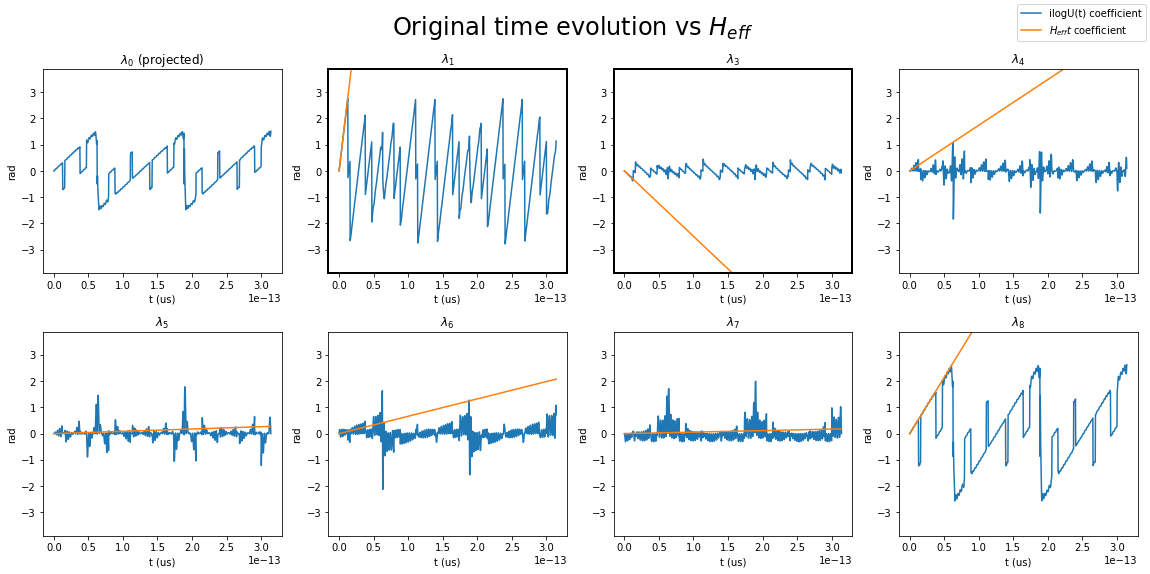

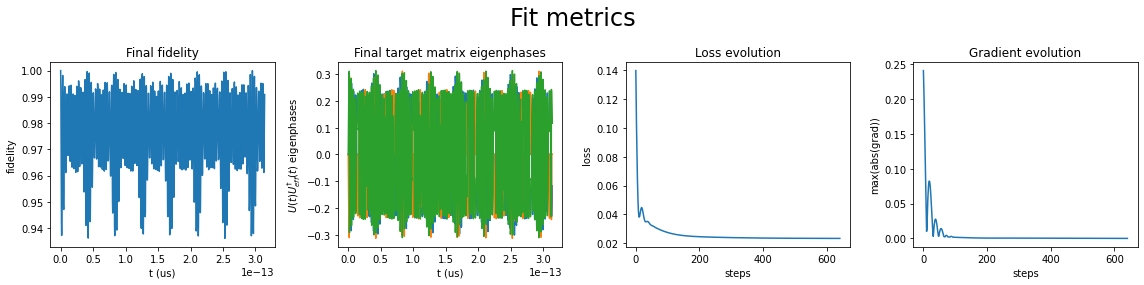

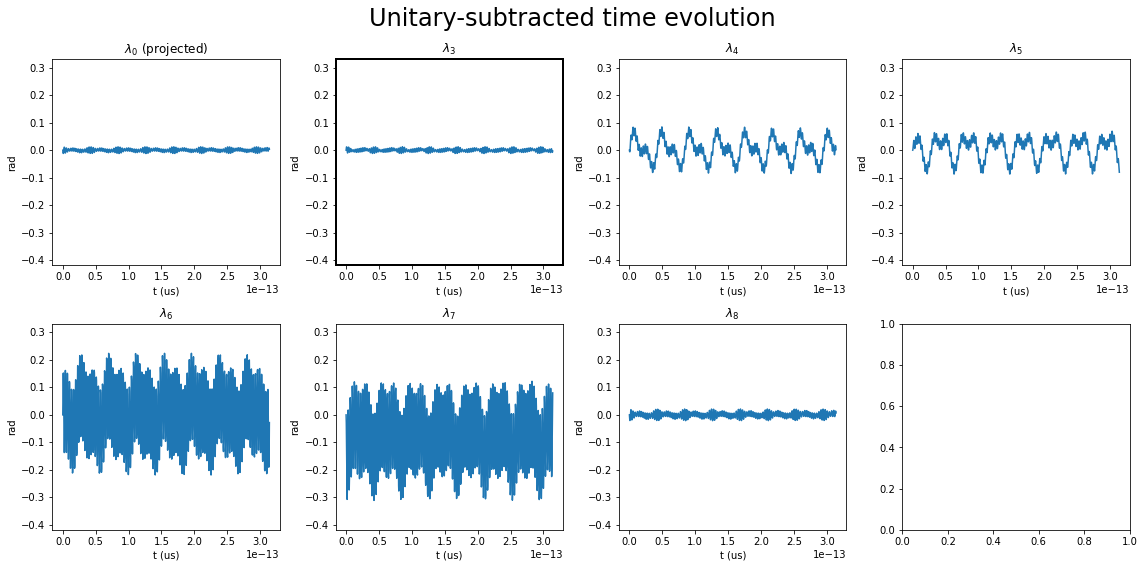

In [5]:
inspect_fidelity_maximization('qubit_resonant_3levels.h5');

### Simulator $H_{\mathrm{eff}}$ amplitude scan from -0.5 to 0.5

In [6]:
run_amplitude_scan = True
amplitudes = np.linspace(-0.5, 0.5, 40)

if run_amplitude_scan:
    drive_def = list({0: {'frequency': params['wq0'], 'amplitude': amp}} for amp in amplitudes)

    heffs = find_heff(
        qubits=0,
        params=params,
        drive_def=drive_def,
        num_sim_levels=3,
        save_result_to='amplitude_scan')
    
else:
    heffs = np.empty(amplitudes.shape + (4,), dtype=np.complex128)

    for iamp in range(amplitudes.shape[0]):
        with h5py.File(f'amplitude_scan/heff_{iamp}.h5', 'r') as source:
            heffs[iamp] = source['heff_coeffs'][()]

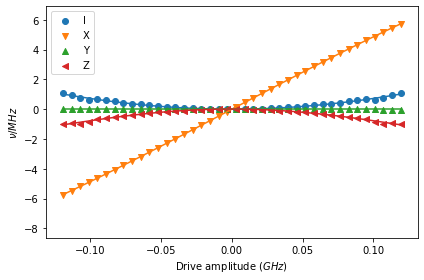

In [7]:
fig, exprs, amp_scale = plot_amplitude_scan(amplitudes * params['omegad0'], heffs)

## Simulation and real-device amplitude scans

We now need to perform the amplitude scan with a finite-width pulse.

### Get the reference backend params and default pulse schedule

In [8]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

params = backend.configuration().hamiltonian['vars']
dt = backend.configuration().dt

x_instr = backend.defaults().instruction_schedule_map.get('x', 0).instructions
ref_pulse = x_instr[0][1].pulse
print(ref_pulse)

Drag(duration=160, amp=(0.18008299338508788+0j), sigma=40, beta=-1.0695777441893135, name='Xp_d0')


### Gaussian pulse amplitude scan

In [10]:
amplitudes = np.linspace(-0.2, 0.2, 20)
duration = ref_pulse.duration * dt

drive_def = list({0: {'frequency': params['wq0'], 'amplitude': Gaussian(0., duration, amp, ref_pulse.sigma * dt)}} for amp in amplitudes)

tlist = np.arange(0., duration, dt)

results = parallel_map(
    run_pulse_sim,
    args=drive_def,
    arg_position=2,
    common_args=(0, params),
    common_kwargs={'psi0': qtp.basis(3, 0), 'tlist': tlist})

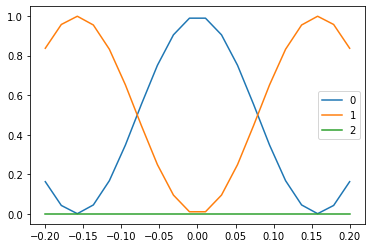

In [11]:
probs = np.array([np.square(np.abs(np.squeeze(result.states[-1]))) for result in results])

plt.plot(amplitudes, probs, label=['0', '1', '2'])
plt.legend();

## IBMQ amplitude scan

In [12]:
schedules = []

for amp in amplitudes:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        drive_chan = pulse.drive_channel(0)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=amp), drive_chan)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])

    schedules.append(sched)

In [13]:
shots = 4096

job = backend.run(schedules, shots=shots)
print(job.job_id())
job_monitor(job)

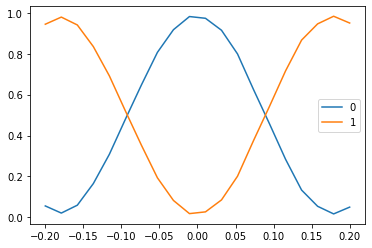

In [14]:
counts = job.result().get_counts()

exp_probs = np.array([[cnt.get('0', 0), cnt.get('1', 0)] for cnt in counts], dtype=float) / shots

plt.plot(amplitudes, exp_probs, label=['0', '1'])
plt.legend()

So the `amp` parameter in qiskit.pulse is more or less really the factor applied to `omegadX`.

## Confirming the $R_{z}$ component in the Gaussian pulse

### Simulator

In [15]:
amplitudes = np.linspace(0.05, 0.8, 16)
drive_def = []
for amp in amplitudes:
    sequence = Sequence([
        Gaussian(0., 160. * dt, amp, 40. * dt),
        Gaussian(160. * dt, 160. * dt, -amp, 40. * dt),
        Gaussian(320. * dt, 160. * dt, amp, 40. * dt),
        Gaussian(480. * dt, 160. * dt, -amp, 40. * dt)
    ])
    
    drive_def.append({0: {'frequency': params['wq0'], 'amplitude': sequence}})
    
tlist = np.arange(0., 640. * dt, 0.1 / (params['wq0'] / twopi))
    
results = parallel_map(
    run_pulse_sim,
    args=drive_def,
    arg_position=2,
    common_args=(0, params),
    common_kwargs={'psi0': qtp.basis(3, 0), 'tlist': tlist})

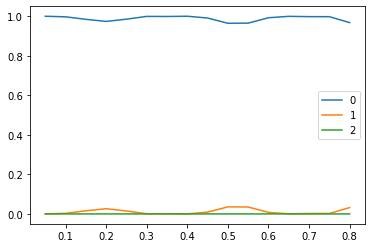

In [16]:
probs = np.array([np.square(np.abs(np.squeeze(result.states[-1]))) for result in results])

plt.plot(amplitudes, probs, label=['0', '1', '2'])
plt.legend()

### IBMQ

In [17]:
schedules = []

for amp in amplitudes:
    with pulse.build(backend=backend, default_alignment='sequential') as sched:
        drive_chan = pulse.drive_channel(0)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=amp), drive_chan)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=-amp), drive_chan)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=amp), drive_chan)
        pulse.play(pulse.Gaussian(duration=ref_pulse.duration, sigma=ref_pulse.sigma, amp=-amp), drive_chan)
        pulse.measure(qubits=[0], registers=[pulse.MemorySlot(0)])

    schedules.append(sched)

In [18]:
shots = 4096

job = backend.run(schedules, shots=shots)
job_monitor(job)

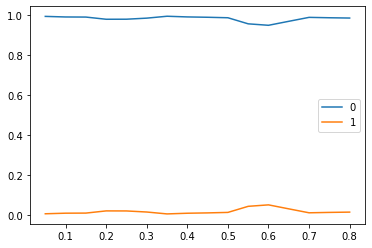

In [19]:
counts = job.result().get_counts()

exp_probs = np.array([[cnt.get('0', 0), cnt.get('1', 0)] for cnt in counts], dtype=float) / shots

plt.plot(amplitudes, exp_probs, label=['0', '1'])
plt.legend()

I guess we are seeing it..